In [1]:
!pip install pandas geopandas folium shapely plotly seaborn matplotlib numpy

import spacy
!python -m spacy download en_core_web_sm
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_geocoder")

import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from shapely import wkt
import re
import csv
import random
from spacy.lang.en.examples import sentences 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import string
from difflib import SequenceMatcher
from geopy.distance import great_circle, GeocoderTimedOut, GeocoderServiceError


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     --------------------------------------- 12.8/12.8 MB 21.8 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


ImportError: cannot import name 'GeocoderTimedOut' from 'geopy.distance' (C:\Users\gayat\Desktop\work\venv\Lib\site-packages\geopy\distance.py)

In [2]:
#Reading the grouped data from the previous one
df = pd.read_csv('\\Users\\gayat\\Desktop\\work\\063023 The Standard.csv')
print(df.columns)
print(df.shape)

Index(['GPE', 'Count', 'Latitude', 'Longitude'], dtype='object')
(20, 4)


In [3]:
# Function to get cleaned city name
def get_cleaned_city_name(latitude, longitude):
    geolocator = Nominatim(user_agent="geocoder")
    location = geolocator.reverse((latitude, longitude), exactly_one=True, language='en')  # Set language to English
    
    if location:
        address = location.raw.get('address', {})
        
        # Directly extract the location name if it exists in the address
        location_name = address.get('city', '') or address.get('town', '') or address.get('state', '') or address.get('country', '')
        
        if location_name:
            return location_name
        else:
            return "Location not found"
    else:
        return "Location not found"

def clean_city_name(city_name):
    remove_patterns = [
        r'^City of ',
        r'^Town of ',
        r'^Village of ',
        r'^Municipality of ',
        r'^County of ',
        r' City$', 
        r' Town$', 
        r' Village$', 
        r' Municipality$', 
        r' County$'
    ]
    
    cleaned_name = city_name
    for pattern in remove_patterns:
        cleaned_name = re.sub(pattern, '', cleaned_name)
    return cleaned_name.strip()

# Apply the function to get cleaned city names and add a new column 'GPE_new'
df['GPE_new'] = df.apply(lambda row: get_cleaned_city_name(row['Latitude'], row['Longitude']), axis=1)

# Save the modified DataFrame to a new CSV file
output_csv = '063023_with_gpe_new_4.csv'  # Replace with your desired output CSV file path
df.to_csv(output_csv, index=False)

In [4]:
#Reading the grouped data from the previous one
df = pd.read_csv('\\Users\\gayat\\Desktop\\work\\063023_with_gpe_new_4.csv')
print(df.columns)
print(df.shape)

Index(['GPE', 'Count', 'Latitude', 'Longitude', 'GPE_new'], dtype='object')
(20, 5)


In [5]:
# Add a column to indicate discrepancies
df['Discrepancy'] = df.apply(lambda row: 1 if row['GPE'] != row['GPE_new'] else 0, axis=1)

# Calculate the total number of discrepancies
total_discrepancies = df['Discrepancy'].sum()

# Sort the DataFrame to have discrepancy rows first
df_sorted = df.sort_values(by='Discrepancy', ascending=False)

# Save the modified DataFrame to a new CSV file
output_csv = '063023_with_discrepancies.csv'  # Replace with your desired output CSV file path
df_sorted.to_csv(output_csv, index=False)

# Print the total number of discrepancies
print(f"Total discrepancies found: {total_discrepancies}")

Total discrepancies found: 10


In [7]:
# Calculate the map center and zoom level as before
south_west_australia_center = [-32.000000, 115.000000]  
map_zoom = 5
mymap = folium.Map(location=south_west_australia_center, zoom_start=map_zoom)

# Set a single color for all the markers
color = "#2F539B" 

def get_marker_size(count):
    scale_factor = 20  
    return 5 + (count / max_count) * scale_factor

# Find the maximum count to use for scaling the marker size
max_count = df["Count"].max()

# Add circle markers with varying size based on the count
for _, row in df.iterrows():
    location = row["GPE_new"]
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    count = row["Count"]
    marker_size = get_marker_size(count)
    popup_text = f"Location: {location}\nCount: {count}"
    folium.CircleMarker([latitude, longitude], popup=popup_text, radius=marker_size, color=color, fill=True, fill_color=color).add_to(mymap)

# Saving the map
mymap.save("scatter_plot_visualization_063023.html")

In [8]:
# Calculate the map center and zoom level as before
south_west_australia_center = [-33.8688197, 151.2092955]  
map_zoom = 5
mymap = folium.Map(location=south_west_australia_center, zoom_start=map_zoom)

# Set a single color for all the markers
color = "#2F539B" 

def get_marker_size(count):
    scale_factor = 5  
    return 5 + (count / max_count) * scale_factor

# Find the maximum count to use for scaling the marker size
max_count = df["Count"].max()

# Add circle markers with varying size based on the count
for _, row in df.iterrows():
    location = row["GPE_new"]
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    count = row["Count"]
    marker_size = get_marker_size(count)
    popup_text = f"Location: {location}\nCount: {count}"
    folium.CircleMarker([latitude, longitude], popup=popup_text, radius=marker_size, color=color, fill=True, fill_color=color).add_to(mymap)

# Saving the map
mymap.save("scatter_plot_visualization_063023_1.html")

In [10]:
specific_location = [-33.8688197, 151.2092955]  # Example coordinates for South-West Australia

# Create a map centered at the specific location with the desired zoom level and tiles
heatmap_map = folium.Map(location=specific_location, zoom_start=10, tiles='Stamen Terrain')

# Create a list of tuples containing the Latitude, Longitude, and Occurrences for each data point
heat_data = list(zip(df['Latitude'], df['Longitude'], df['Count']))

# Add the HeatMap layer to the map with custom gradient and opacity
HeatMap(heat_data, gradient={0.4: 'blue', 0.65: 'green', 1: 'red'}, opacity=0.7, radius=15, blur=20).add_to(heatmap_map)

# Display the heatmap
heatmap_map.save('heatmap_map_063023.html')


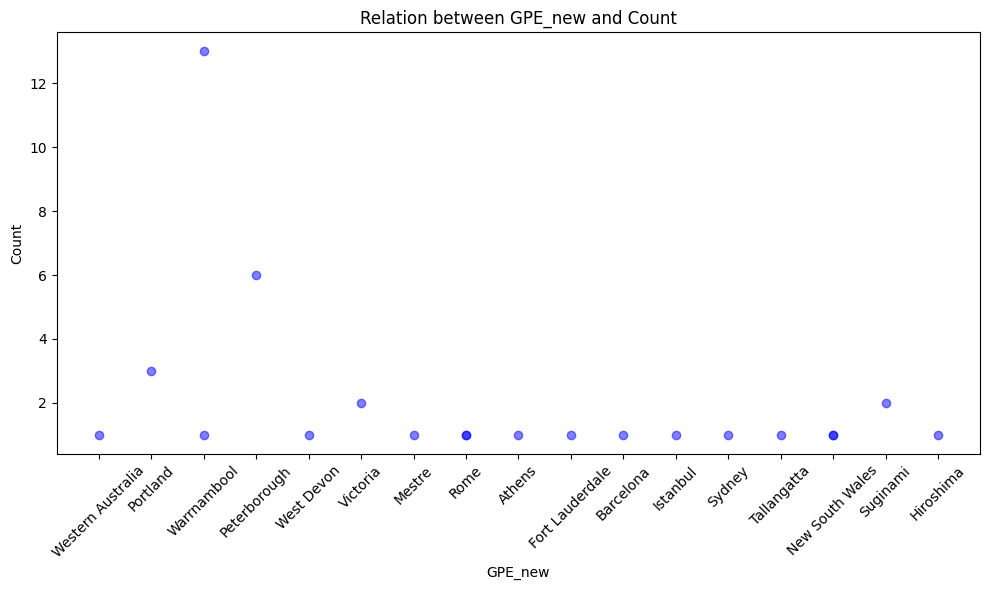

In [14]:
# Extract the 'GPE_new' and 'count' columns
gpe_new = df['GPE_new']
count = df['Count']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(gpe_new, count, color='blue', alpha=0.5)
plt.xlabel('GPE_new')
plt.ylabel('Count')
plt.title('Relation between GPE_new and Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()